In [ ]:
import zipfile

zip_path = '/content/dataset gabungan.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_hub as hub
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings("ignore")

# Data Processing

In [ ]:
IMAGE_SIZE = 224  # Ukuran gambar setelah resize
BATCH_SIZE = 32   # Ukuran batch
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
CLASSES = ['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']  # Nama kelas
train_dir = "/content/dataset sekunder+primer/train"
test_dir = "/content/dataset sekunder+primer/test"

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
  label_mode ="categorical"
)

Found 7302 files belonging to 4 classes.
Using 5842 files for training.


In [ ]:
val = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
  label_mode ="categorical"
)

Found 7302 files belonging to 4 classes.
Using 1460 files for validation.


In [ ]:
test = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
  label_mode ="categorical"
)

Found 1825 files belonging to 4 classes.


In [ ]:
# Terapkan caching, pengacakan, dan prefetching pada dataset pelatihan
train_dataset_final = (
    train
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

# Terapkan caching dan prefetching pada dataset validasi
validation_dataset_final = (
    val
    .cache()
    .prefetch(PREFETCH_BUFFER_SIZE)
)

# Terapkan caching dan prefetching pada dataset test
test_dataset_final = test.cache().prefetch(PREFETCH_BUFFER_SIZE)

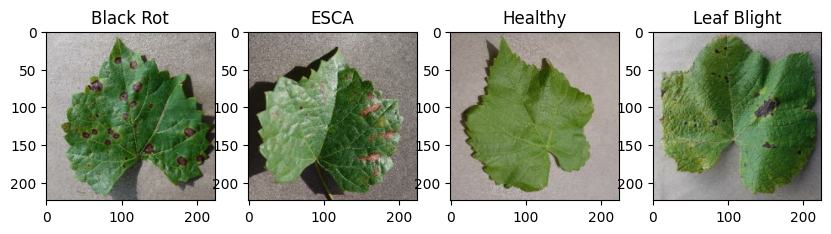

In [ ]:
# Mengambil contoh gambar dari batch pertama dalam train_dataset
class_names = ['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']
num_classes = len(class_names)
example_images = {class_name: None for class_name in class_names}

# Iterasi batch untuk mengambil satu contoh dari setiap kelas
for images, labels in train.take(1):  # hanya satu batch
    for i in range(len(images)):
        class_index = np.argmax(labels[i])  # Mendapatkan index kelas
        class_name = class_names[class_index]

        if example_images[class_name] is None:  # Hanya mengambil satu contoh per kelas
            example_images[class_name] = images[i]

# Menampilkan contoh gambar
plt.figure(figsize=(10, 10))
for i, (class_name, img) in enumerate(example_images.items()):
    plt.subplot(1, num_classes, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("on")
plt.show()


# Data Augmentation dan Rescaling

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

# Model

In [ ]:
def create_cvnn_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), n_classes=len(CLASSES)):
    model = models.Sequential([
        # Preprocessing (resize, rescale, dan augmentasi)
        layers.Input(shape=input_shape),
        resize_and_rescale,  # Resize dan rescale jika sudah didefinisikan sebelumnya
        data_augmentation,   # Augmentasi data jika sudah ada augmentasi sebelumnya

        # Layer Convolutional dan MaxPooling
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),  # Feature extraction
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        # Flatten dan Fully Connected Layer
        layers.Flatten(),
        layers.Dense(128, activation="relu"),  # Hidden layer
        layers.Dropout(0.5),  # Regularization untuk mengurangi overfitting

        # Output layer
        layers.Dense(num_classes, activation="softmax")  # Klasifikasi multi-kelas
    ])

    return model

# Membuat model
model = create_cvnn_model()


In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,479,492 (24.72 MB)

 Trainable params: 6,479,492 (24.72 MB)

 Non-trainable params: 0 (0.00 B)

# Pelatihan Model

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Pantau loss validasi
    patience=3,          # Hentikan setelah 3 epoch tanpa perbaikan
    restore_best_weights=True  # Kembalikan bobot terbaik
)

# Pelatihan model dengan callback early stopping
EPOCHS = 30
history = model.fit(
    train_dataset_final,
    validation_data=validation_dataset_final,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 62s 179ms/step - accuracy: 0.6184 - loss: 0.8941 - val_accuracy: 0.7705 - val_loss: 0.5758
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.8422 - loss: 0.4391 - val_accuracy: 0.7644 - val_loss: 0.6421
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.8813 - loss: 0.3208 - val_accuracy: 0.9000 - val_loss: 0.2494
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.9079 - loss: 0.2644 - val_accuracy: 0.9137 - val_loss: 0.2072
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - accuracy: 0.9119 - loss: 0.2472 - val_accuracy: 0.9404 - val_loss: 0.1541
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9457 - loss: 0.1746 - val_accuracy: 0.9178 - val_loss: 0.2033
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.9405 - loss: 0.1619 - val_accuracy: 0.9452 - val_loss: 0.1582
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9570 - loss: 0

# Evaluasi Model

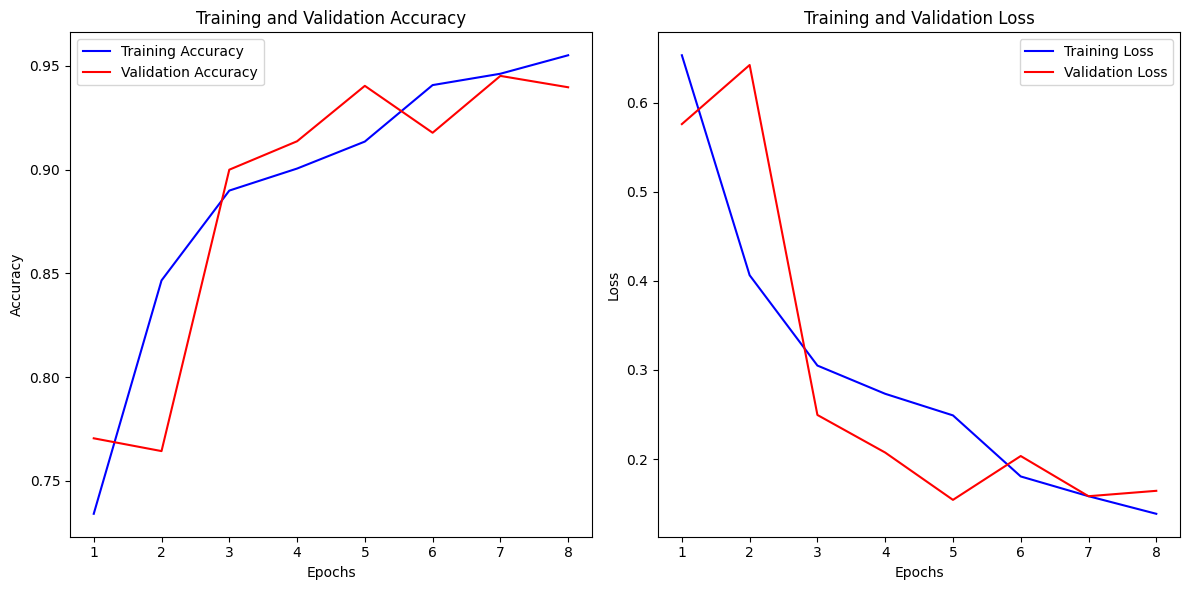

In [ ]:
# Ekstrak akurasi dan loss dari history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Buat plot
epochs = range(1, len(train_acc) + 1)  # Jumlah epoch yang dijalankan

plt.figure(figsize=(12, 6))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Akurasi dan Loss akhir
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Final Training Accuracy: 0.9552
Final Validation Accuracy: 0.9397


In [ ]:
# Evaluasi pada data uji
test_loss, test_accuracy = model.evaluate(test_dataset_final)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.9545 - loss: 0.1404
Test Accuracy: 0.9474
Test Loss: 0.1541


Saving e751fc65-f484-4022-9ea8-a4199a8cc67a___FAM_B.Rot 3432_flipLR.JPG to e751fc65-f484-4022-9ea8-a4199a8cc67a___FAM_B.Rot 3432_flipLR.JPG


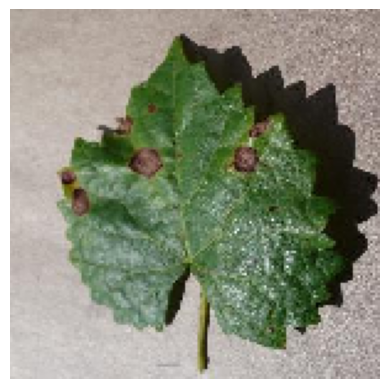

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediksi: Black Rot dengan probabilitas: 0.70
Gambar: e751fc65-f484-4022-9ea8-a4199a8cc67a___FAM_B.Rot 3432_flipLR.JPG


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

    path = fn
    img = image.load_img(path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    classes = model.predict(x)

    predicted_class = np.argmax(classes[0])

    print(f'Prediksi: {class_names[predicted_class]} dengan probabilitas: {classes[0][predicted_class]:.2f}')
    print(f'Gambar: {fn}')

# Save Model

In [ ]:
model.save("saved_model_potato_CNN.keras")
model = tf.keras.models.load_model("saved_model_potato_CNN.keras")

In [ ]:
model.save_weights("model_potato_CNN_tf.weights.h5")